In [50]:
import numpy as np
from numpy.linalg import svd, norm, eigh
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

url = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64"

df = pd.read_csv(url)

In [51]:
# Define transformation functions according to FRED-MD specifications
def identity(x: pd.Series) -> pd.Series:
    return x

def lag1(x: pd.Series) -> pd.Series:
    return x.shift(1)

def diff(x: pd.Series) -> pd.Series:
    return x.diff()

def diff2(x: pd.Series) -> pd.Series:
    return x.diff().diff()

def logdiff(x: pd.Series) -> pd.Series:
    return np.log(x) - np.log(x.shift(1))

def logdiff2(x: pd.Series) -> pd.Series:
    return (np.log(x) - np.log(x.shift(1))).diff()

def diffp(x: pd.Series) -> pd.Series:
    return ((x / x.shift(1)) - 1).diff()

def logd(x: pd.Series) -> pd.Series:
    x = x.copy()
    x[x <= 0] = np.nan
    return np.log(x)


# Create a tuple of transformation functions indexed by tcode
tfuns = [identity, diff, diff2, logd, logdiff, logdiff2, diffp]

In [52]:
def df_cleaning(df):
    df_onlydata = df.iloc[1:-1].copy()
    df_onlydata['sasdate'] = pd.to_datetime(df_onlydata['sasdate'], format='%m/%d/%Y')
    df_onlydata = df_onlydata[
        (df_onlydata['sasdate'] >= pd.Timestamp(1960, 1, 1)) &
        (df_onlydata['sasdate'] <= pd.Timestamp(2025, 3, 1))
    ]

    # Extract transformation codes and convert to int - 1
    tcode = df.iloc[0, 1:].astype(float) - 1  # exclude 'sasdate' column

    for i, col in enumerate(df_onlydata.columns[1:]):  # skip 'sasdate'
        trcode = int(tcode.iloc[i])
        if 0 <= trcode < len(tfuns):
            df_onlydata[col] = tfuns[trcode](df_onlydata[col])
        else:
            raise ValueError(f"Invalid transformation code {trcode} for column {col}")

    return df_onlydata.reset_index(drop=True), tcode


fredmd, tcode = df_cleaning(df)

In [53]:
def mark_outliers_as_missing(df:pd.DataFrame, k:int = 10.0):
    """
    Identifies and marks extreme outliers in a DataFrame as missing (NaN) values.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing numeric columns and a 'sasdate' column (which is excluded).
        k (int or float, optional): Multiplier for the IQR-based outlier detection threshold. 
                                    Observations more than k * IQR away from the median are marked as NaN. 
                                    Default is 10.0.

    Returns:
        pd.DataFrame: Modified DataFrame with extreme outliers replaced by NaN in each column except 'sasdate'.

    Notes:
        - Outliers are defined as values that differ from the median by more than k times the interquartile range (IQR).
        - The function operates column-wise and skips NaN values when computing statistics.
    """
    df_copy = df.copy()
    for col in df.columns.drop('sasdate'):
        x = df[col]
        xclean = x.dropna()
        q25, median, q75 = xclean.quantile([0.25, 0.5, 0.75])
        iqr = q75 - q25
        threshold = k * iqr
        mask = (x - median).abs() >= threshold
        df.loc[mask, col] = np.nan
    number_of_outliers_removed = df.isna().sum().sum() - df_copy.isna().sum().sum() 
    print(f'Removed {number_of_outliers_removed} outliers')
    return df

fredmd_nooutliers = mark_outliers_as_missing(fredmd)


Removed 157 outliers


In [54]:
def pc2(X,nfac):
    '''' =========================================================================
     DESCRIPTION
     This function runs principal component analysis.

     -------------------------------------------------------------------------
     INPUTS
               X      = dataset (one series per column)
               nfac   = number of factors to be selected

     OUTPUTS
               chat  f = values of X predicted by the factors
               fhat   = factors scaled by (1/sqrt(N)) where N is the number of
                        series
               lambda = factor loadings scaled by number of series
               ss     = eigenvalues of X'*X

     ========================================================================= '''

    N = X.shape[1]  # Number of series in X (i.e. number of columns)
    # The rows of vh are the eigenvectors of A'A and the columns of u are the eigenvectors of AA'.
    # In both cases the corresponding (possibly non-zero) eigenvalues are given by s**2.
    U, S, Vh = np.linalg.svd(X.T@X) # Singular value decomposition: X'*X = U*S*V where V=U'

    lambda_ = U[:, :nfac]*np.sqrt(N)   # Factor loadings scaled by sqrt(N)
    fhat = np.dot(X, lambda_)*(1/N)  # Factors scaled by 1/sqrt(N) (note that lambda is scaled by sqrt(N))
    chat = np.dot(fhat, lambda_.T) # Estimate initial dataset X using the factors (note that U'=inv(U))
    ss = S                          #  a vector of singular values of X'*X, eigenvalues are ss**2??

    return chat, fhat, lambda_, ss

In [55]:
def pca_em_missing(df: pd.DataFrame, r: int, max_iter: int = 1000, tol: float = 1e-6):
    """
    PCA with EM algorithm to handle missing values (Stock and Watson, 2002).

    Parameters:
        df: pandas DataFrame with a 'sasdate' column and other numeric columns (some may have NaNs).
        r: number of static factors.
        max_iter: max number of EM iterations.
        tol: relative convergence tolerance for factors.

    Returns:
        F: T x r matrix of estimated factors (standardized)
        Lambda: N x r matrix of factor loadings (standardized)
        X_completed: T x N DataFrame with missing values imputed (in original scale)
    """
    # Separate date and data columns
    date_col = df['sasdate'].reset_index(drop=True) #crea una serie con solo le date, droppa l'indice
    X_raw = df.drop(columns=['sasdate']).to_numpy() #X è il df senza le date
    T, N = X_raw.shape #T = numero di righe, N = numero di colonne
    mask = ~np.isnan(X_raw) #Una maschera con true dove non ci sono i NaN

    # Initial mean and std ignoring NaNs
    mu = np.nanmean(X_raw, axis=0) #fa la media per colonna ignorando i NaN
    sigma = np.nanstd(X_raw, axis=0) #fa la st.dev pre colonna ignorando i Nan
    #-------------------------------------------------------------------------------------
    sigma[sigma == 0] = 1.0  # Avoid division by zero ///Impone una st.dev di 1 se è 0////
    #-------------------------------------------------------------------------------------

    # Standardize and initialize missing with zero
    X_std = (X_raw - mu) / sigma #crea un nuovo df con le colonne standardizzate
    X_std[np.isnan(X_std)] = 0 #mette 0 al posto dei NaN


    #inizializza F
    F_old = np.zeros((T, r)) #crea un array con tutti 0 di T righe(numero di righe di X) e r colonne(numero di fattori richiesto)

    for iteration in range(max_iter):
        # PCA via SVD
        X_std = np.nan_to_num(X_std, nan=0.0, posinf=0.0, neginf=0.0) #Replace NaN with zero and infinity with 0 
        # U, S, Vt = svd(X_std, full_matrices=False) #fa la singol value decomposition
        # # decompone X in U*S*V'
        # F_new = U[:, :r] * S[:r]  # T x r
        # Lambda = Vt[:r, :].T      # N x r

        # # Normalize Lambda: (Lambda.T @ Lambda) / N = I_r
        # C = (Lambda.T @ Lambda) / N 
        # eigvals, eigvecs = eigh(C) #calcola eigenvalues and eigenvector of C, C deve essere simmetrica
        # eigvals = np.clip(eigvals, 1e-10, None) #replace tutti gli eigenvalues minori di 1e-10 con 1e-10
        # C_inv_sqrt = eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T
        # Lambda = Lambda @ C_inv_sqrt


        # Check convergence (relative)
        # if iteration > 0:
        #     delta = norm(F_new - F_old) / norm(F_old)
        #     if delta < tol:
        #         break

        # Impute missing values
        # X_hat = F_new @ Lambda.T #crea una matrice di valori simulati
        # X_hat = X_hat * sigma + mu  # De-standardize
        X_hat, F_new, Lambda,ss = pc2(X_std,r)
        X_completed = X_raw.copy() #copia X_raw
        X_completed[~mask] = X_hat[~mask] #Mette i valori simulati su X completed dove prima c'erano i NaN

        # Recompute standardization stats
        mu = np.mean(X_completed, axis=0)
        sigma = np.std(X_completed, axis=0)
        sigma[sigma == 0] = 1.0
        X_std = (X_completed - mu) / sigma #Standardizza di nuovo aggiornando X_std con i nuovi valori simulati

        F_old = F_new #Aggiorna F

    # Return completed DataFrame with 'sasdate'
    completed_df = pd.DataFrame(X_completed, columns=df.columns.drop('sasdate'))
    completed_df.insert(0, 'sasdate', date_col)
    #completed_df.fillna(0, inplace=True)  # Safety

    return F_new, Lambda, completed_df


In [56]:
F, Lambda, completed_df = pca_em_missing(fredmd_nooutliers, 8)

In [57]:
completed_df.isna().sum().sum() 

np.int64(0)

In [58]:
import matplotlib.pyplot as plt

def plot_factors(F: np.ndarray, dates: pd.Series):
    """
    Plot estimated factors over time.

    Parameters:
        F: T x r matrix of estimated factors
        dates: pd.Series of datetime values (e.g., from 'sasdate' column)
    """
    r = F.shape[1]
    plt.figure(figsize=(12, r * 2.5))
    for i in range(r):
        plt.subplot(r, 1, i + 1)
        plt.plot(dates, F[:, i])
        plt.title(f'Factor {i + 1}')
        plt.tight_layout()
    plt.show()


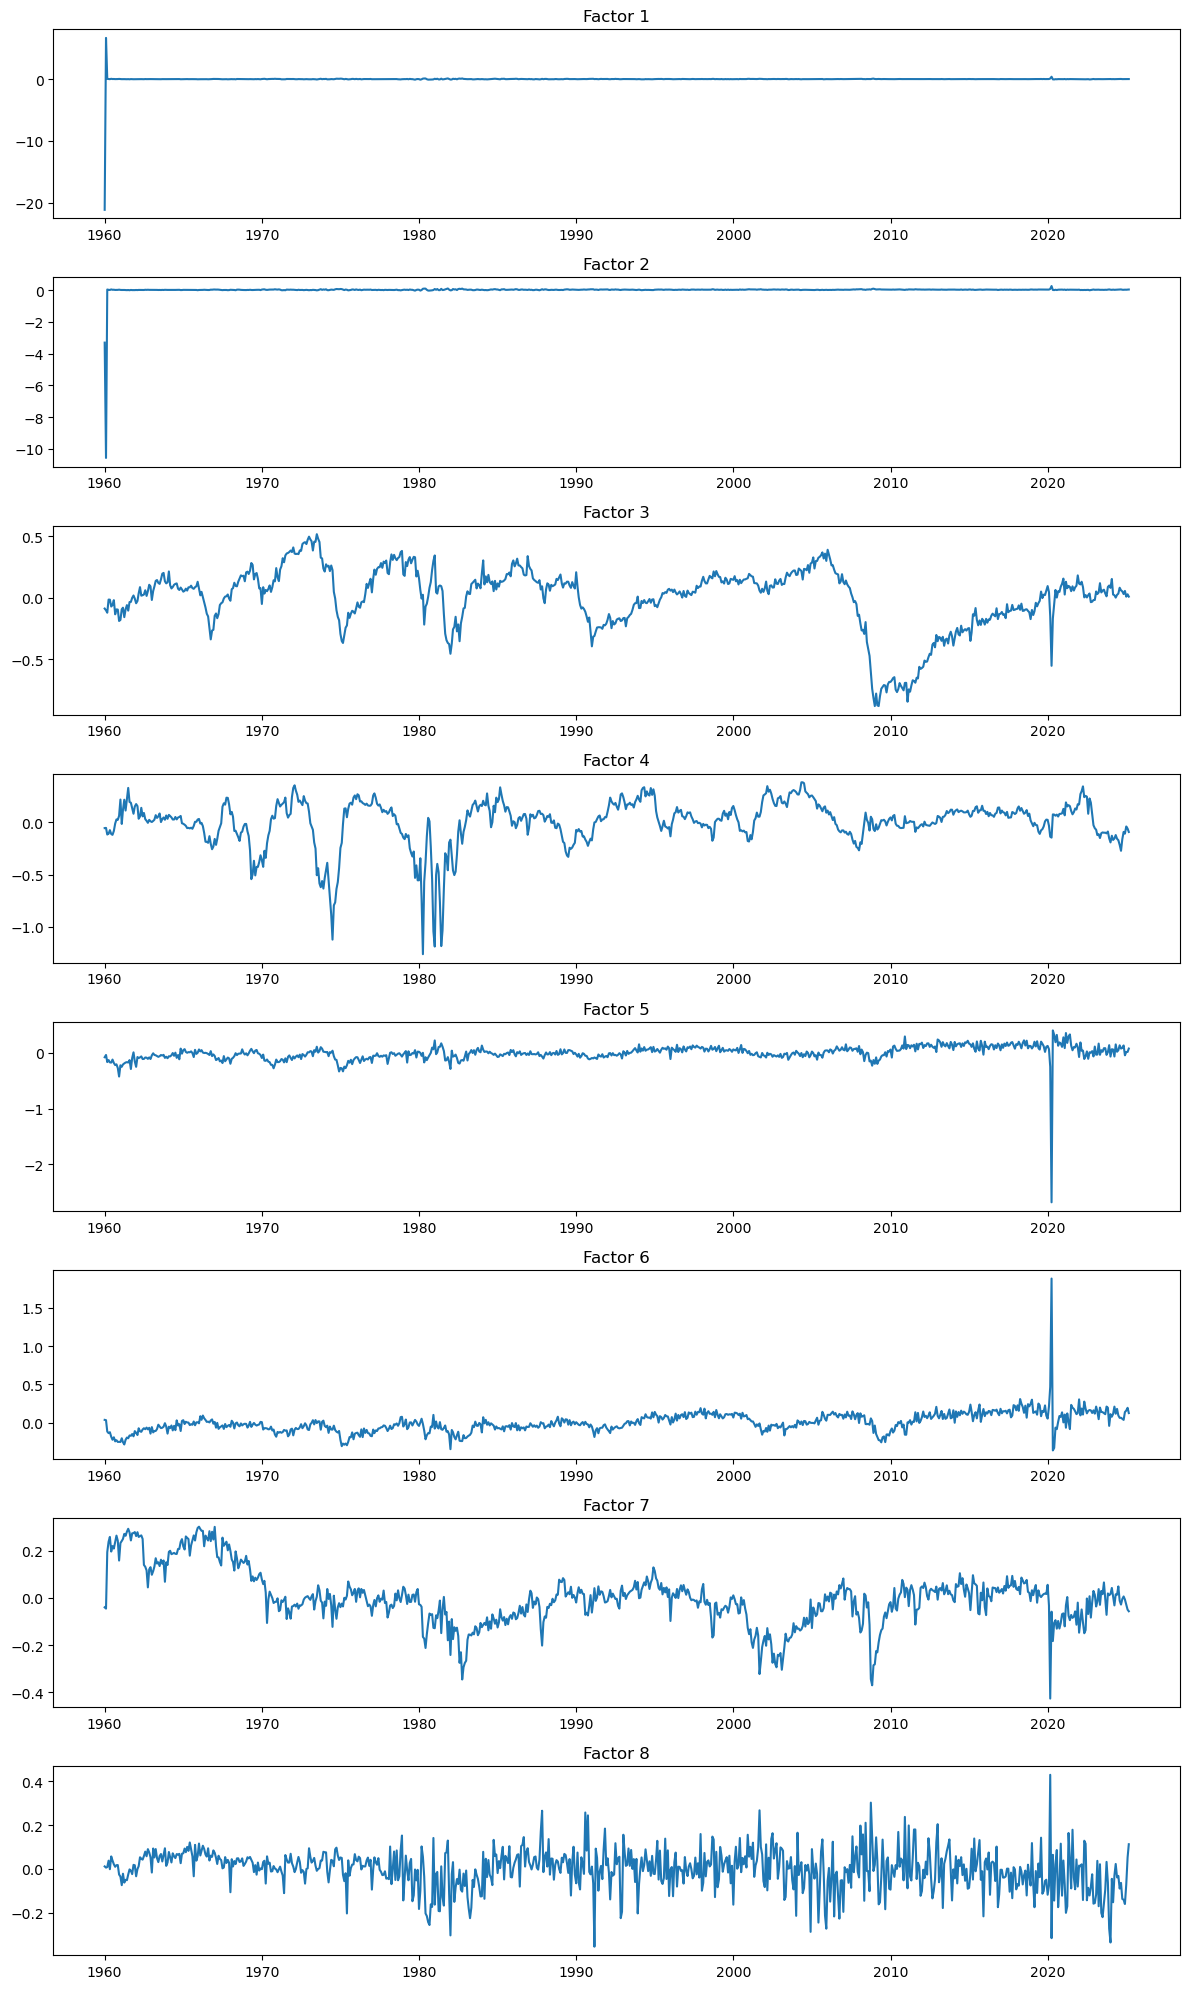

In [59]:
dates = completed_df['sasdate']
plot_factors(F, dates)

In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Step 1: Estrai i dati numerici (senza la colonna 'sasdate')
X = completed_df.drop(columns=['sasdate'])
T, N = X.shape
r = F.shape[1]

# Step 2: Calcola R² per ogni serie su ciascun fattore (uno alla volta)
r2_table = {f'Factor {j+1}': {} for j in range(r)}

for col in X.columns:
    y = X[col].values.reshape(-1, 1)
    for j in range(r):
        x = F[:, j].reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        r2_table[f'Factor {j+1}'][col] = r2

# Step 3: Costruisci la tabella dei top 10 per ciascun fattore
top_r2_df = pd.DataFrame()
for factor, scores in r2_table.items():
    top_series = sorted(scores.items(), key=lambda x: -x[1])[:10]
    series_names, r2_values = zip(*top_series)
    top_r2_df[f'{factor} - Series'] = series_names
    top_r2_df[f'{factor} - R²'] = r2_values

print("🔟 Top 10 series per factor:\n")
print(top_r2_df.to_string(index=False))

# ✅ Step 4: Calcola la media R² per ciascun fattore (mR²)
mean_r2 = {}
for j in range(r):
    r2s = []
    for col in X.columns:
        y = X[col].values.reshape(-1, 1)
        x = F[:, j].reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        r2s.append(model.score(x, y))
    mean_r2[f'Factor {j+1}'] = np.mean(r2s)

# Tabella dei mR²
mR2_df = pd.DataFrame.from_dict(mean_r2, orient='index', columns=['mR²'])
mR2_df.index.name = 'Factor'

print("\n📊 Mean R² per Factor (mR²):")
print(mR2_df.round(4))


🔟 Top 10 series per factor:

Factor 1 - Series  Factor 1 - R² Factor 2 - Series  Factor 2 - R² Factor 3 - Series  Factor 3 - R² Factor 4 - Series  Factor 4 - R² Factor 5 - Series  Factor 5 - R² Factor 6 - Series  Factor 6 - R² Factor 7 - Series  Factor 7 - R² Factor 8 - Series  Factor 8 - R²
            IPMAT       0.909434            ACOGNO       0.622925             HOUST       0.930204            T5YFFM       0.798525         COMPAPFFx       0.481887     CES0600000007       0.421020           VIXCLSx       0.474547          UMCSENTx       0.565763
           IPDMAT       0.909434              M2SL       0.557287            PERMIT       0.822699            T1YFFM       0.785660            AWHMAN       0.395458            AWHMAN       0.387460           PERMITS       0.215695            CONSPI       0.162450
           INDPRO       0.909358              M1SL       0.518157            HOUSTW       0.796243          TB6SMFFM       0.772409     CES0600000007       0.389968          UEMPM

# Forecast

In [62]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from itertools import product
from statsmodels.tools.eval_measures import bic
from sklearn.metrics import mean_squared_error

def create_lags(data, max_lag):
    """Create lagged versions of a 1D array."""
    return np.column_stack([np.roll(data, lag) for lag in range(1, max_lag + 1)])

def recursive_factor_forecast(df, factor, target_var, h, start_date, end_date,
                               max_ar_lag=6, max_f_lag=3):
    """
    Recursive forecast for a target variable using lagged factors and AR terms.

    Parameters:
        df: DataFrame with 'sasdate' and target_var.
        factor: np.ndarray of shape (T, r), typically use F[:, 0] for the first factor.
        target_var: name of the target variable (str).
        h: forecast horizon (1, 6, or 12).
        start_date, end_date: string or datetime (e.g. '1990-01').
        max_ar_lag: max AR order for y.
        max_f_lag: max lag order for the factor.

    Returns:
        forecast_df: DataFrame with ['sasdate', 'actual', 'forecast', 'ar_lag', 'f_lag']
        mse: mean squared error of forecasts
    """
    dates = pd.to_datetime(df['sasdate'])
    y = df[target_var].values
    f = factor[:, 0]  # use first factor

    start_idx = dates[dates >= pd.to_datetime(start_date)].index[0]
    end_idx = dates[dates <= pd.to_datetime(end_date)].index[-1] - h

    results = []

    for t in range(start_idx, end_idx + 1):
        y_train = y[:t]
        f_train = f[:t]

        best_bic = np.inf
        best_model = None
        best_X = None
        best_lags = (0, 0)

        for ar_lag, f_lag in product(range(max_ar_lag + 1), range(1, max_f_lag + 1)):
            min_len = max(ar_lag, f_lag)
            T_eff = len(y_train) - min_len - h + 1
            if T_eff <= 0:
                continue

            X = []
            Y = []

            for i in range(min_len, len(y_train) - h + 1):
                x_row = []
                if ar_lag > 0:
                    x_row += list(y_train[i - ar_lag:i][::-1])
                x_row += list(f_train[i - f_lag:i][::-1])
                X.append(x_row)
                Y.append(y_train[i + h - 1])

            X = np.array(X)
            Y = np.array(Y)

            if len(Y) < 5:
                continue

            model = LinearRegression().fit(X, Y)
            y_pred = model.predict(X)
            residuals = Y - y_pred
            T_val = len(Y)
            k_val = X.shape[1]
            rss = np.sum(residuals ** 2)
            model_bic = T_val * np.log(rss / T_val) + k_val * np.log(T_val)
            if model_bic < best_bic:
                best_bic = model_bic
                best_model = model
                best_X = x_row
                best_lags = (ar_lag, f_lag)

        # Forecast for t+h
        ar_lag, f_lag = best_lags
        x_fore = []
        if ar_lag > 0:
            x_fore += list(y[t - ar_lag:t][::-1])
        x_fore += list(f[t - f_lag:t][::-1])
        x_fore = np.array(x_fore).reshape(1, -1)
        forecast = best_model.predict(x_fore)[0]

        results.append({
            'sasdate': dates[t + h],
            'actual': y[t + h],
            'forecast': forecast,
            'ar_lag': ar_lag,
            'f_lag': f_lag
        })

    forecast_df = pd.DataFrame(results)

    # Compute MSE
    mse = mean_squared_error(forecast_df['actual'], forecast_df['forecast'])

    return forecast_df, mse


In [63]:
def construct_annualized_target(df, col, h):
    """
    Compute annualized h-step log-diff growth for a log-diffed series.

    Parameters:
        df: DataFrame with transformed log-diffed series (e.g. INDPRO)
        col: column name of the diff-log series
        h: forecast horizon (e.g. 1, 6, 12)

    Returns:
        pd.Series: (1200/h) * sum of h forward monthly log-diffs
    """
    growth_h = df[col].rolling(window=h).sum().shift(-h)
    annualized = (1200 / h) * growth_h
    return annualized


In [64]:
def forecast_all_windows_and_horizons(completed_df, F, base_col='INDPRO'):
    """
    Runs recursive forecasts for h in {1, 6, 12} across 3 forecast windows.
    
    Parameters:
        completed_df: DataFrame with 'sasdate' and transformed INDPRO
        F: factor matrix (T x r), use F[:, 0] for the first factor
        base_col: name of the diff-log variable (default 'INDPRO')

    Returns:
        full_results_df: DataFrame with all forecasts and MSEs
    """
    forecast_windows = {
        '1970-2003': ('1970-01', '2003-12'),
        '1990-2003': ('1990-01', '2003-12'),
        '2008-2014': ('2008-01', '2014-12'),
    }

    all_results = []

    for h in [1, 6, 12]:
        # Costruisci la variabile target annualizzata
        target_series = construct_annualized_target(completed_df, base_col, h)
        df_h = completed_df.copy()
        target_col = f'{base_col}_h{h}'
        df_h[target_col] = target_series

        for label, (start_date, end_date) in forecast_windows.items():
            forecast_df, mse = recursive_factor_forecast(
                df=df_h,
                factor=F,
                target_var=target_col,
                h=h,
                start_date=start_date,
                end_date=end_date
            )
            forecast_df['window'] = label
            forecast_df['h'] = h
            forecast_df['mse'] = mse
            print(f"✅ {label}, h={h} → MSE = {round(mse, 4)}")
            all_results.append(forecast_df)

    full_results_df = pd.concat(all_results).reset_index(drop=True)
    return full_results_df


In [65]:
results = forecast_all_windows_and_horizons(completed_df, F)

✅ 1970-2003, h=1 → MSE = 76.1203
✅ 1990-2003, h=1 → MSE = 34.3795
✅ 2008-2014, h=1 → MSE = 86.9248
✅ 1970-2003, h=6 → MSE = 34.273
✅ 1990-2003, h=6 → MSE = 12.0674
✅ 2008-2014, h=6 → MSE = 38.4279
✅ 1970-2003, h=12 → MSE = 22.2582
✅ 1990-2003, h=12 → MSE = 7.9323
✅ 2008-2014, h=12 → MSE = 8.8418


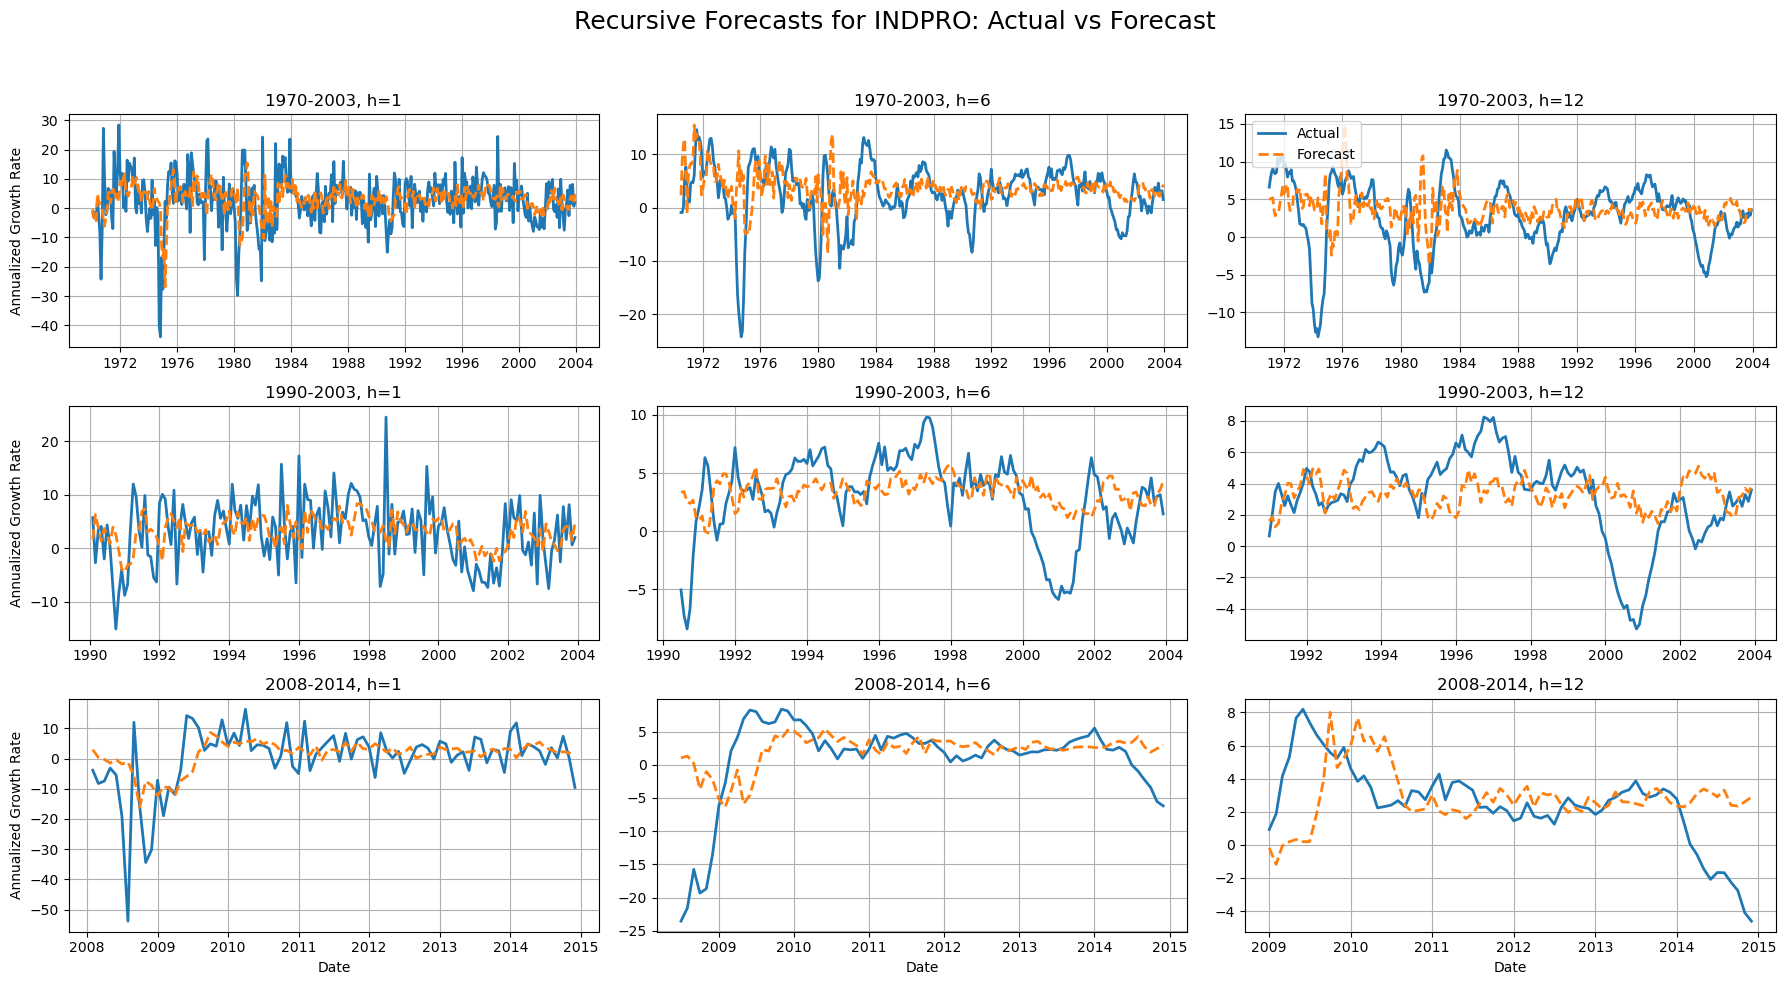

In [66]:
# Definisci ordine fisso per finestre e orizzonti
forecast_windows_order = ['1970-2003', '1990-2003', '2008-2014']
horizons_order = [1, 6, 12]

# Crea figura
fig, axs = plt.subplots(3, 3, figsize=(18, 10), sharex=False)
fig.suptitle('Recursive Forecasts for INDPRO: Actual vs Forecast', fontsize=18)

# Loop su finestre (righe) e orizzonti (colonne)
for i, window in enumerate(forecast_windows_order):
    for j, h in enumerate(horizons_order):
        ax = axs[i, j]
        subset = results[(results['window'] == window) & (results['h'] == h)]

        ax.plot(subset['sasdate'], subset['actual'], label='Actual', linewidth=2)
        ax.plot(subset['sasdate'], subset['forecast'], label='Forecast', linestyle='--', linewidth=2)

        ax.set_title(f"{window}, h={h}", fontsize=12)
        ax.grid(True)

        if i == 2:
            ax.set_xlabel('Date')
        if j == 0:
            ax.set_ylabel('Annualized Growth Rate')

        if i == 0 and j == 2:
            ax.legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [67]:
def construct_cpi_target(df, col, h):
    """
    (1200/h)*log(CPI_{t+h}/CPI_t) - 1200*log(CPI_t/CPI_{t-1})
    """
    cpi = df[col]
    term1 = (1200 / h) * (np.log(cpi.shift(-h)) - np.log(cpi))
    term2 = 1200 * (np.log(cpi) - np.log(cpi.shift(1)))
    return term1 - term2


In [68]:
def forecast_all_cpi_windows_and_horizons(df_raw, completed_df, F, col="CPIAUCSL"):
    forecast_windows = {
        '1970-2003': ('1970-01', '2003-12'),
        '1990-2003': ('1990-01', '2003-12'),
        '2008-2014': ('2008-01', '2014-12'),
    }

    all_results = []

    for h in [1, 6, 12]:
        target_series = construct_cpi_target(df_raw, col, h)
        df_h = completed_df.copy()
        target_col = f'{col}_h{h}'
        df_h[target_col] = target_series

        # Elimina righe con NaN in target
        df_h = df_h[df_h[target_col].notna()].copy()

        for label, (start_date, end_date) in forecast_windows.items():
            try:
                forecast_df, mse = recursive_factor_forecast(
                    df=df_h,
                    factor=F,
                    target_var=target_col,
                    h=h,
                    start_date=start_date,
                    end_date=end_date
                )
                forecast_df['window'] = label
                forecast_df['h'] = h
                forecast_df['mse'] = mse
                print(f"✅ {label}, h={h} → MSE = {round(mse, 4)}")
                all_results.append(forecast_df)
            except Exception as e:
                print(f"⚠️ Skipped {label}, h={h} due to: {e}")

    return pd.concat(all_results).reset_index(drop=True)


In [69]:
results_cpi = forecast_all_cpi_windows_and_horizons(df, completed_df, F)

✅ 1970-2003, h=1 → MSE = 12.8455
✅ 1990-2003, h=1 → MSE = 6.8619
✅ 2008-2014, h=1 → MSE = 17.5835
✅ 1970-2003, h=6 → MSE = 7.5454
✅ 1990-2003, h=6 → MSE = 4.6419
✅ 2008-2014, h=6 → MSE = 24.3216
✅ 1970-2003, h=12 → MSE = 7.3372
✅ 1990-2003, h=12 → MSE = 3.908
✅ 2008-2014, h=12 → MSE = 24.8262


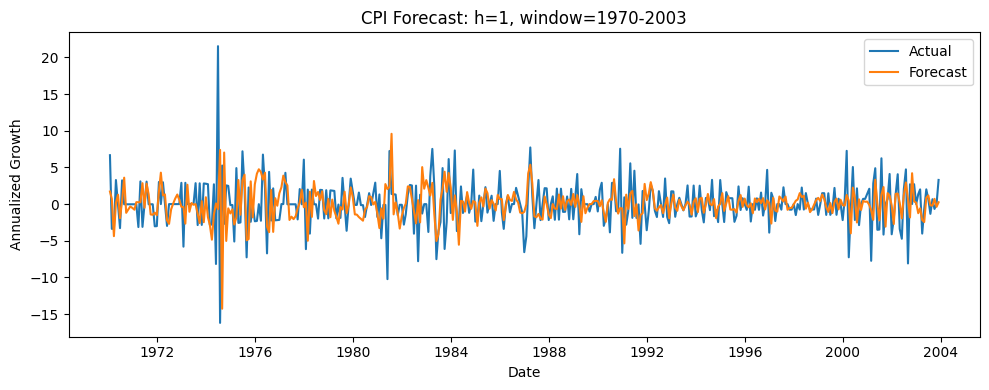

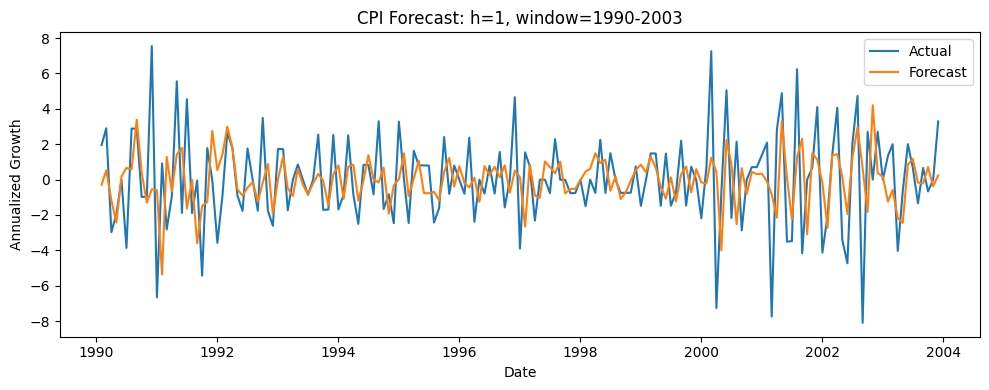

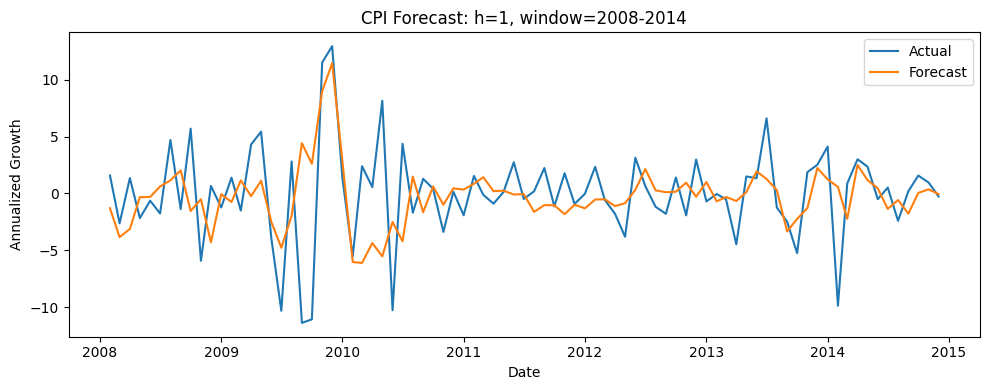

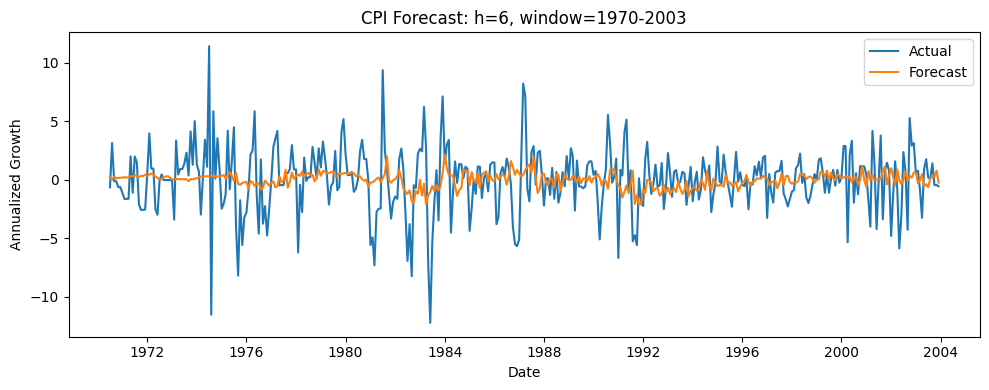

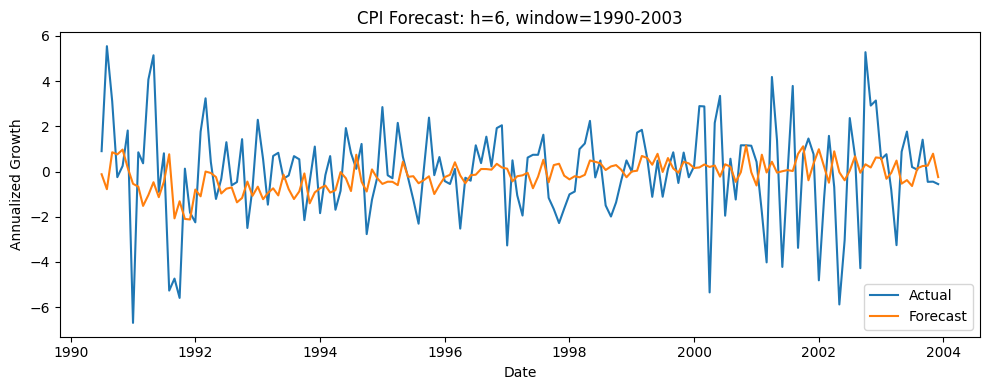

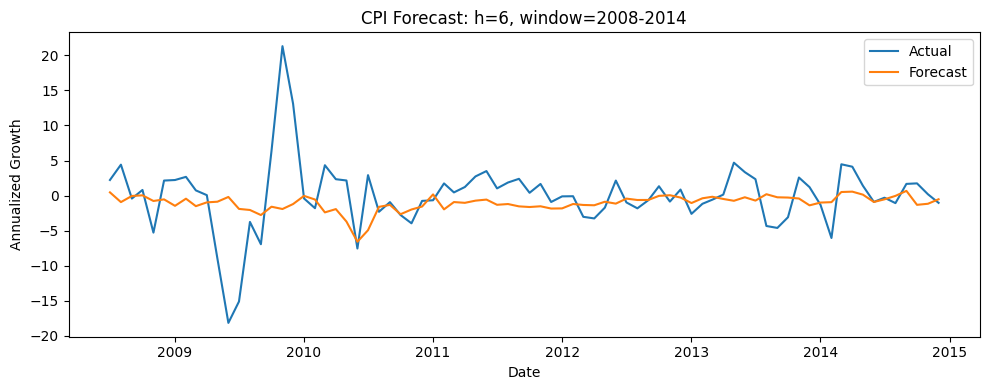

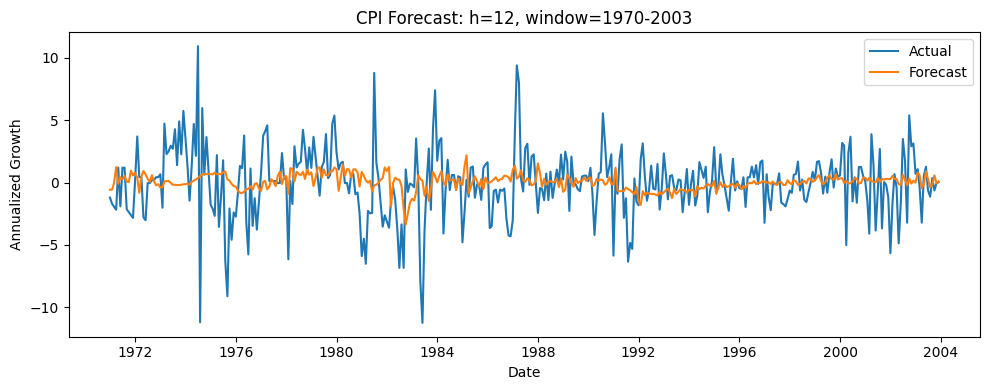

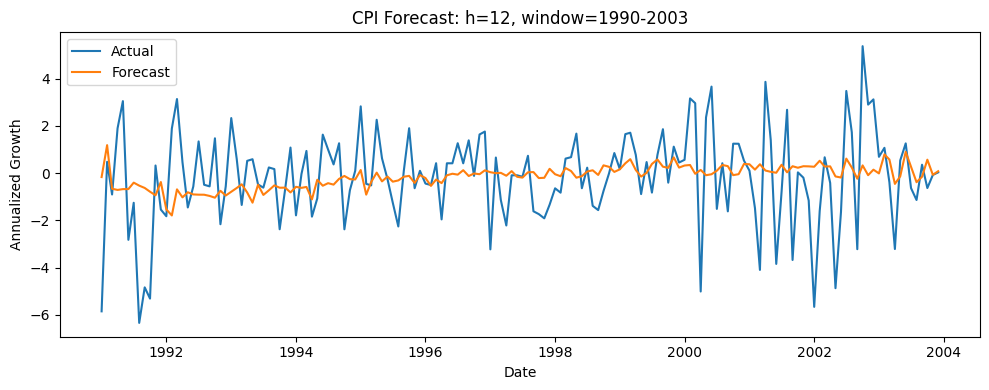

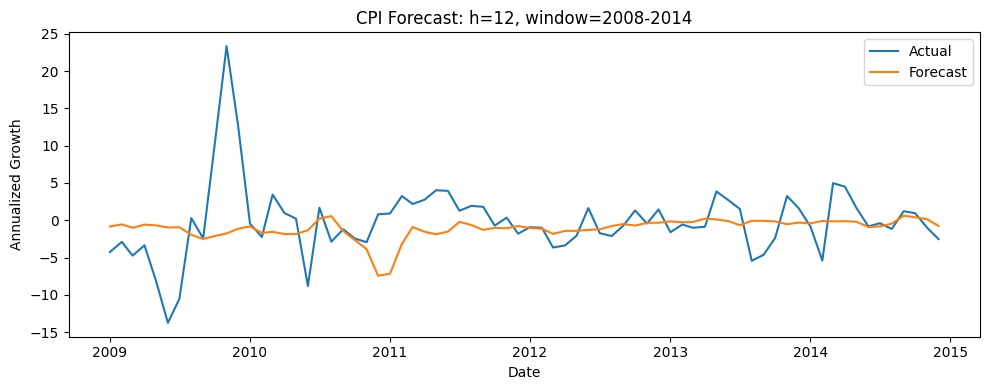

In [68]:
for h in [1, 6, 12]:
    for window in ['1970-2003', '1990-2003', '2008-2014']:
        sub = results_cpi[(results_cpi['h'] == h) & (results_cpi['window'] == window)]
        if sub.empty: continue

        plt.figure(figsize=(10, 4))
        plt.plot(sub['sasdate'], sub['actual'], label='Actual')
        plt.plot(sub['sasdate'], sub['forecast'], label='Forecast')
        plt.title(f'CPI Forecast: h={h}, window={window}')
        plt.xlabel('Date')
        plt.ylabel('Annualized Growth')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [106]:
def forecast_next_6_months(df_raw, completed_df, F, target_level_col="INDPRO", cpi_col="CPIAUCSL"):
    # Allinea lunghezza con F
    df_raw_aligned = df_raw[-len(completed_df):].reset_index(drop=True)
    
    # Date future
    last_date = pd.to_datetime(df_raw_aligned['sasdate']).iloc[-1]
    next_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=6, freq='MS')
    
    factor = F[:, 0]

    # === Forecast INDPRO (livello) ===
    log_indpro = np.log(df_raw_aligned[target_level_col].astype(float))
    growth_indpro = log_indpro.diff().to_numpy()

    X_ip = factor[1:].reshape(-1, 1)
    y_ip = growth_indpro[1:]
    model_ip = LinearRegression().fit(X_ip, y_ip)
    growth_forecast = model_ip.predict(factor[-6:].reshape(-1, 1))

    last_log_level = log_indpro.iloc[-1]
    level_forecast = [np.exp(last_log_level + np.sum(growth_forecast[:i+1])) for i in range(6)]

    # === Forecast CPI (Δ semplice) ===
    cpi_level = df_raw_aligned[cpi_col].astype(float)
    cpi_diff = cpi_level.diff().to_numpy()

    X_cpi = factor[1:].reshape(-1, 1)
    y_cpi = cpi_diff[1:]
    model_cpi = LinearRegression().fit(X_cpi, y_cpi)
    cpi_forecast = model_cpi.predict(factor[-6:].reshape(-1, 1))

    # === Output DataFrame ===
    forecast_df = pd.DataFrame({
        "sasdate": next_dates,
        "forecast_level_indpro": level_forecast,
        "forecast_diff_cpi": cpi_forecast,
        "forecast_annualized_growth_indpro": growth_forecast * 1200
    })

    return forecast_df


In [108]:
forecast_6m = forecast_next_6_months(df, completed_df, F)

In [109]:
def plot_extended_forecast_last12_and_forecast6(df_raw, forecast_df):
    # Pulizia e parsing delle date
    df_clean = df_raw.copy()
    df_clean = df_clean[df_clean['sasdate'].str.len() >= 7]
    df_clean['sasdate'] = pd.to_datetime(df_clean['sasdate'], errors='coerce')
    df_clean = df_clean.dropna(subset=['sasdate'])
    df_clean = df_clean.sort_values('sasdate')

    # --- Plot INDPRO ---
    indpro = df_clean[['sasdate', 'INDPRO']].dropna()
    indpro_recent = indpro.iloc[-12:]  # ultimi 12 mesi

    plt.figure(figsize=(10, 4))
    plt.plot(indpro_recent['sasdate'], indpro_recent['INDPRO'], label='Observed (last 12 months)', linewidth=2)
    plt.plot(forecast_df['sasdate'], forecast_df['forecast_level_indpro'], label='Forecast (next 6 months)', linestyle='--', linewidth=2)
    plt.title("📈 Industrial Production (INDPRO) – Level Forecast")
    plt.xlabel("Date")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot CPI ---
    cpi = df_clean[['sasdate', 'CPIAUCSL']].dropna()
    cpi['CPI_diff'] = cpi['CPIAUCSL'].diff()
    cpi_recent = cpi.dropna().iloc[-12:]  # ultimi 12 mesi con diff

    plt.figure(figsize=(10, 4))
    plt.plot(cpi_recent['sasdate'], cpi_recent['CPI_diff'], label='Observed Inflation (ΔCPI)', linewidth=2)
    plt.plot(forecast_df['sasdate'], forecast_df['forecast_diff_cpi'], label='Forecast (next 6 months)', linestyle='--', linewidth=2)
    plt.title("📉 Inflation – Forecast of First Difference of CPI")
    plt.xlabel("Date")
    plt.ylabel("Δ CPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/var/folders/18/_mxjgyjn4yndvln604zhc8mc0000gn/T/ipykernel_36635/3762202670.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['sasdate'] = pd.to_datetime(df_clean['sasdate'], errors='coerce')
/var/folders/18/_mxjgyjn4yndvln604zhc8mc0000gn/T/ipykernel_36635/3762202670.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


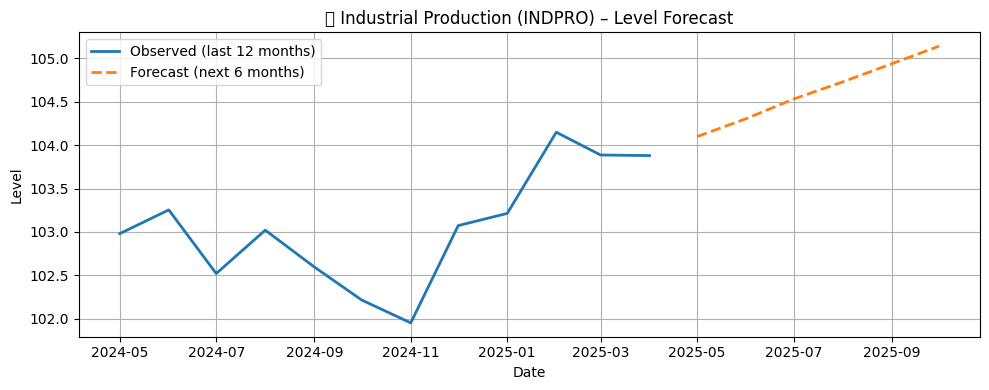

/var/folders/18/_mxjgyjn4yndvln604zhc8mc0000gn/T/ipykernel_36635/3762202670.py:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


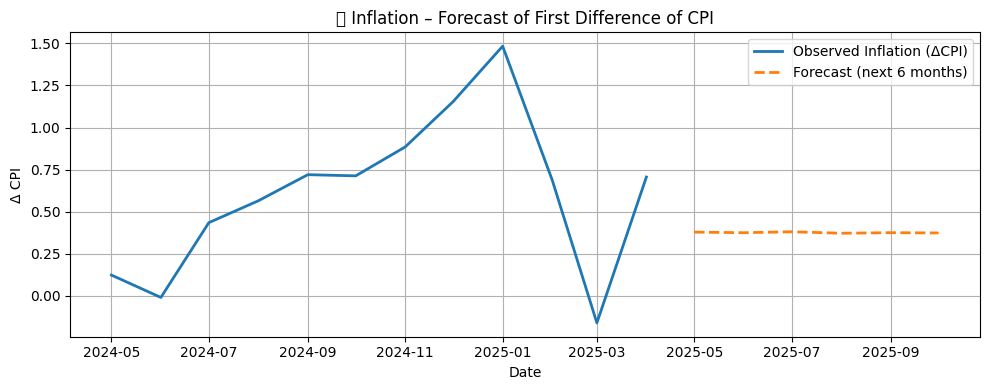

In [110]:
plot_extended_forecast_last12_and_forecast6(df, forecast_6m)